## Get file artifacts


In [56]:
def get_artifacts(file_path: str, artifact_key: str):
    with open(file_path, 'r') as data_file:
        data = data_file.read()
    arts = [art.strip() for art in data.split('##')]
    return [art for art in arts if art.startswith(artifact_key)]

artifacts = {}
artifacts['Requisitos'] = get_artifacts('../docs/artifacts/requirements.md', 'REQ')
artifacts['Especificações'] = get_artifacts('../docs/artifacts/specifications.md', 'SPEC')
artifacts['Casos de teste'] = get_artifacts('../docs/artifacts/testcase.md', 'TCASE')
artifacts['Procedimentos de teste'] = get_artifacts('../docs/artifacts/testprocedure.md', 'TPROD')

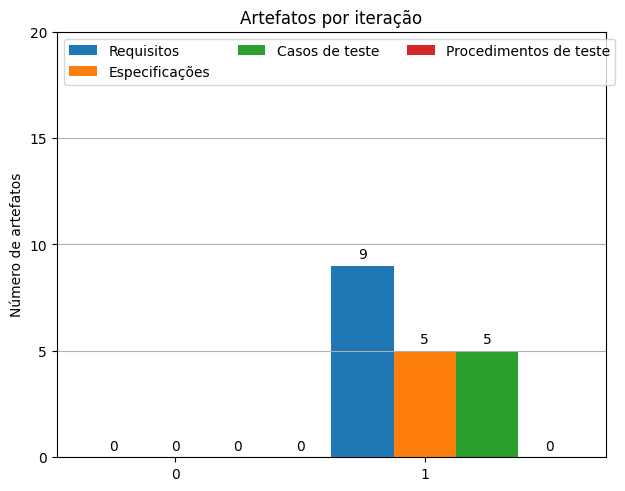

In [67]:
import matplotlib.pyplot as plt
import numpy as np

iteration_indexes = (0, 1)
artifacts_series = {title: [0] for title in artifacts.keys()}
for title, values in artifacts.items():
    artifacts_series[title].append(len(values))

x = np.arange(len(iteration_indexes))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in artifacts_series.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de artefatos')
ax.set_title('Artefatos por iteração')
ax.set_xticks(x + width, iteration_indexes)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 20)
ax.set_yticks(range(0,21,5))
ax.grid(True,'both','y')



plt.show()

In [70]:
fig.savefig("../docs/assets/plots/artifact_series.svg")